<a href="https://colab.research.google.com/github/python-freak/Generating-MNIST-images-with-GANS/blob/master/simple_gan_v_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import mnist
from keras.models import Sequential , Model
from keras.layers import Dense , Dropout , Input
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt 

Using TensorFlow backend.


In [2]:
# loading the dataset 
(x_train , y_train) , (x_test , y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# preprocessing the data
x_train = x_train.reshape(-1 , 784)
x_test = x_test.reshape(-1 , 784)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [4]:
z_dim = 100
adam = Adam(lr = 0.0001 , beta_1 = 0.5)

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
gen = Sequential()
gen.add(Dense(256 , input_dim = z_dim , activation = LeakyReLU(alpha = 0.2)))
gen.add(Dense(512 , activation = LeakyReLU(alpha = 0.2)))
gen.add(Dense(1024 , activation = LeakyReLU(alpha = 0.2)))
gen.add(Dense(784 , activation = 'sigmoid'))
gen.compile(loss = 'binary_crossentropy' , optimizer = adam , metrics = ['accuracy'])

d = Sequential()
d.add(Dense(1024 , input_dim = 784 , activation = LeakyReLU(alpha = 0.2)))
d.add(Dropout(0.4))
d.add(Dense(512 , activation = LeakyReLU(alpha = 0.2)))
d.add(Dropout(0.4))
d.add(Dense(256 , activation = LeakyReLU(alpha = 0.2)))
d.add(Dropout(0.4))
d.add(Dense(1 , activation = 'sigmoid'))
d.compile(loss = 'binary_crossentropy' , optimizer = adam , metrics = ['accuracy'])

d.trainable = False
inputs = Input(shape = (z_dim , ))
gen_img = gen(inputs)
output = d(gen_img)
gan = Model(inputs , output)
gan.compile(loss = 'binary_crossentropy' , optimizer = adam , metrics = ['accuracy'])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [0]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    #d_acc = [v[1] for v in losses["D"]]
    #g_acc = [v[1] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    #plt.plot(d_acc, label="Discriminator accuracy")
    #plt.plot(g_acc, label="Generator accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = gen.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [0]:
losses = {"D":[] , "G":[] }

def train(epochs = 1 , plt_frq = 1 , batch_size = 128):
  batchcount = int(x_train.shape[0] / batch_size)
  print("Epochs:",epochs)
  print("Batch Size:",batch_size)
  print("Batches per epoch:",batchcount)
  
  for e in tqdm_notebook(range(1 , epochs+1)):
    if e==1 or e%plt_frq == 0:
      print('-'*15 , 'Epoch %d' % e , '-'*15)
    for _ in range(batchcount):
      
      image_batch = x_train[np.random.randint(0 , x_train.shape[0] , size = batch_size)]
      noise = np.random.normal(0 , 1 , size = (batch_size , z_dim))
      
      gen_imgs = gen.predict(noise)
      X = np.concatenate((image_batch , gen_imgs))
      y = np.zeros(2*batch_size)
      y[:batch_size] = 0.9
      
      d.trainable = True
      d_loss = d.train_on_batch(X , y)
      
      noise = np.random.normal(0 , 1 , size = (batch_size , z_dim))
      y2 = np.ones(batch_size)
      d.trainable = False
      g_loss = gan.train_on_batch(noise , y2)
      
    losses["D"].append(d_loss)
    losses["G"].append(g_loss)
    
    if e==1 or e%plt_frq == 0:
      plot_generated()
  plot_loss(losses)

Epochs: 200
Batch Size: 256
Batches per epoch: 234


--------------- Epoch 1 ---------------
Instructions for updating:
Use tf.cast instead.


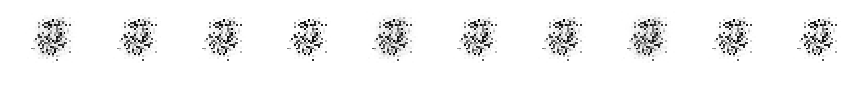

--------------- Epoch 20 ---------------


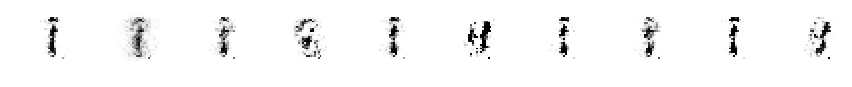

--------------- Epoch 40 ---------------


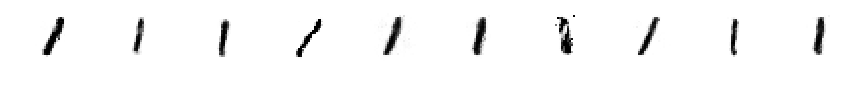

--------------- Epoch 60 ---------------


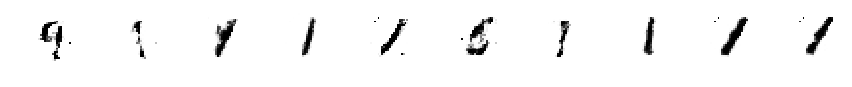

--------------- Epoch 80 ---------------


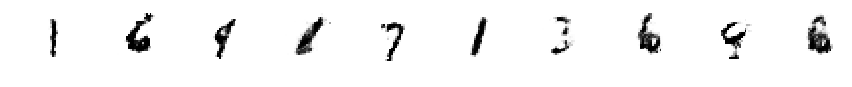

--------------- Epoch 100 ---------------


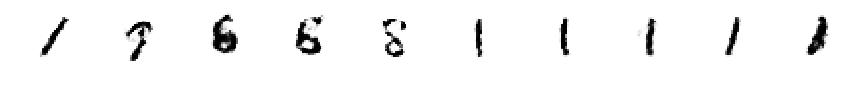

--------------- Epoch 120 ---------------


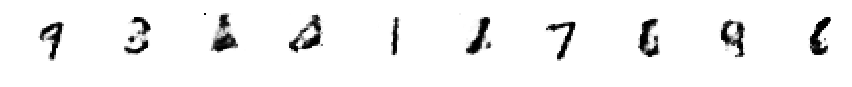

--------------- Epoch 140 ---------------


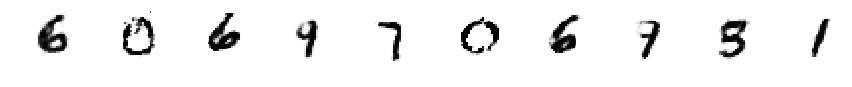

--------------- Epoch 160 ---------------


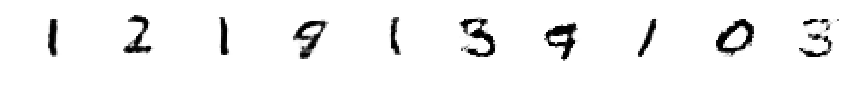

--------------- Epoch 180 ---------------


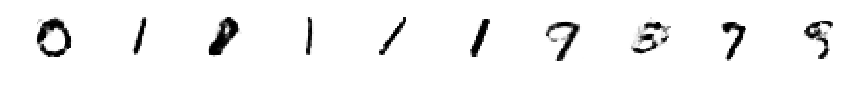

--------------- Epoch 200 ---------------


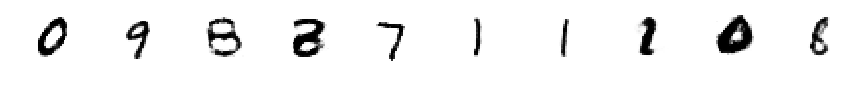

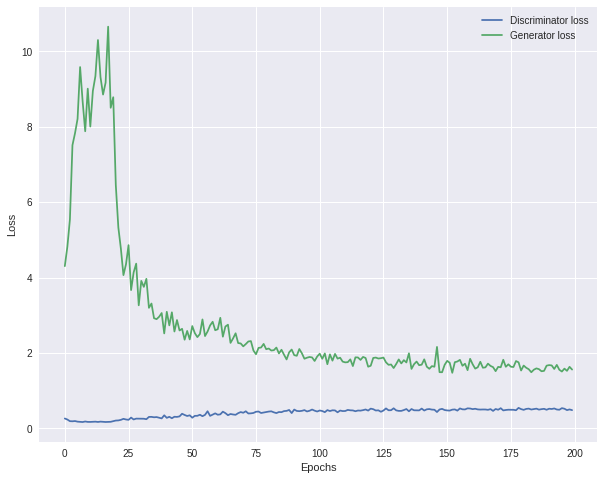

In [8]:
train(epochs = 200 , plt_frq = 20 , batch_size = 256)